# Aim of this document is to create a model of the FWt with Gravity acting as an external force and linerise the EoM about all ifxed points (across velocities)

In [6]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2
import FwtModels.AeroModels as ams

me.mechanics_printing()

### Define the problem

In [7]:
# define FWTD mass and mass ratio
FWTD_mass = 1
ratio = 16
inner_freq = 2


# create the variables
p = dof2.FwtParameters.Default2DoF() # parameter container

# set values for independent symbols
p.s.value = 1
p.c.value = 0.15
p.g.value = 9.81
p.rho.value = 1.225
p.a_t.value = 2 * np.pi
p.alpha_r.value = np.deg2rad(5)
p.Lambda.value = np.deg2rad(25)

p.m.value = FWTD_mass
p.sigma = dof2.FwtVariable(ratio,'sigma')   #mass ratio

# set expression for dependent symbols
p.k = (sym.Integer(inner_freq)*2*sym.pi)**2*(p.m*(p.sigma+sym.Integer(1)))
p.m_w = p.m*p.sigma
p.I_xx = sym.Rational(1,12)*p.m*p.s**2*1
p.l = p.s*sym.Rational(1,2)


p.g.value = 9.81*1
p.alpha_r.value == np.deg2rad(5)

# potential Energy
half = sym.Rational(1,2)
U = half*p.k*(p.q[1])**2

# Transforms for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,p.q[1])
fwt_frame = wing_frame.R_x(p.q[0])
fwt_com_frame = fwt_frame.Translate(0,p.l,0)
rot = sym.Matrix([p.q[0],0,0])

mw = dof2.RigidElement.PointMass(wing_frame,sym.Matrix([0,0,0]),p.m_w)
M_fwt = dof2.MassMatrix(p.m,I_xx = p.I_xx)
m = dof2.RigidElement(fwt_com_frame,rot,M_fwt)

# External Forces
AeroForces = ams.AeroModelv1(p,fwt_frame,at_mode=1)
GravityForces = ams.GravityModel(p,fwt_com_frame,sym.Matrix([0,0,p.g*p.m]))
CompositeForce = ams.CompositeForce([GravityForces,AeroForces])

# create instance of the model
sM = dof2.SymbolicModel(U,[mw,m],p,ExtForces = CompositeForce)

### Determine the fixed points of this system

In [8]:
#make alternative dataset
from scipy.optimize import minimize
vs = np.linspace(0,90,301)

df = pd.DataFrame(columns=['v','aoa','eta','q1','Lambda'])

def ToMinimise(x,p):
    val = sM.deriv(0,[x[0],0,x[1],0],p)
    return val[1]**2 + val[3]**2

Lambdas = [10,25]
for lam in Lambdas:
    guess = [np.pi/2,0]
    p.Lambda.value = np.deg2rad(lam)
    for v in vs:
        p.V.value = v        
        guess = minimize(ToMinimise,guess,args=(p)).x
        df = df.append({'aoa' : np.rad2deg(p.alpha_r.value), 'v' : v,'eta':guess[0],'q1':guess[1],'Lambda':lam} , ignore_index=True)

df[r'$\eta [Deg]$']= np.rad2deg(df['eta'])

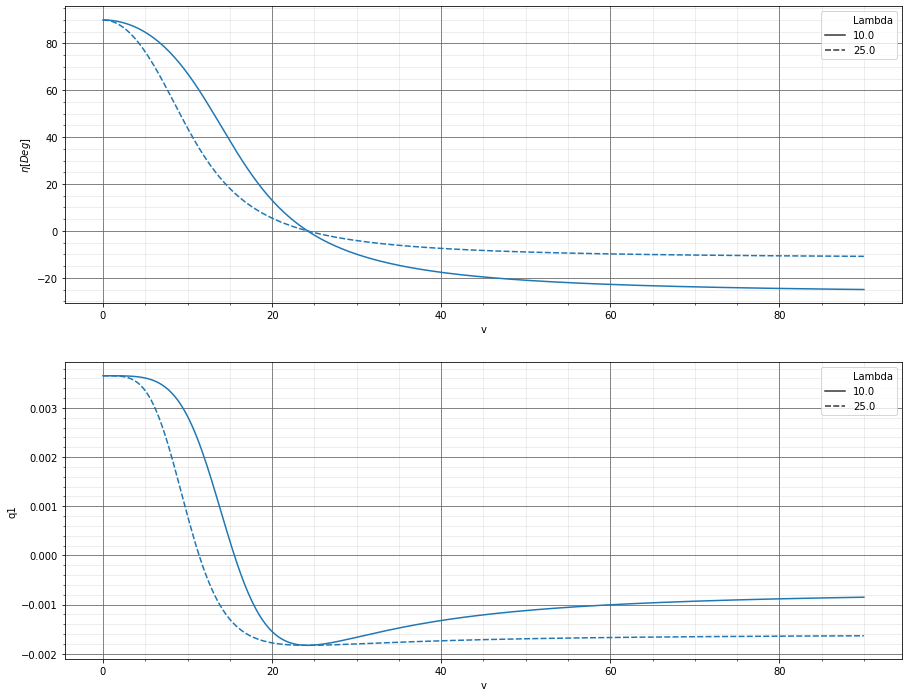

In [9]:
# plot the data
fig, axes = plt.subplots(2,1,figsize=(15,12))
df[r'$\eta [Deg]$']= np.rad2deg(df['eta'])
sns.lineplot(data=df,y=r'$\eta [Deg]$',x='v',style='Lambda',ax=axes[0])

sns.lineplot(data=df,y='q1',x='v',style='Lambda',ax=axes[1])

for ax in axes:
    #ax.set(xlim=(0,80))
    ax.grid(b=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

### Linearise the system about some fixed points

In [10]:
# create complete EoM

func = dof2.LinearEoM_func(sM,p,ignore=[p.V,p.Lambda,p.sigma])

In [13]:
data = df

flutdfv2 = pd.DataFrame()
for ratio in [15,100]:    
    for i in range(0,len(data)):  
        # get the fixed point
        lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]
        # get the jacobian evaluated at this point
        j_lp = func(data['v'].iloc[i],np.deg2rad(data['Lambda'].iloc[i]),ratio,lp)
        # get eigen value information
        jac_dat = dof2.ExtractEigenValueData(j_lp,sortby='Damping')
        # populate test specific data   
        jac_dat['V'] = data['v'].iloc[i]
        jac_dat['Mass Ratio'] = f'r = {ratio}'
        jac_dat['lp'] = [lp for i in range(0,len(jac_dat))]
        jac_dat['Lambda'] = data['Lambda'].iloc[i]
        flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True)
#flutdfv2   

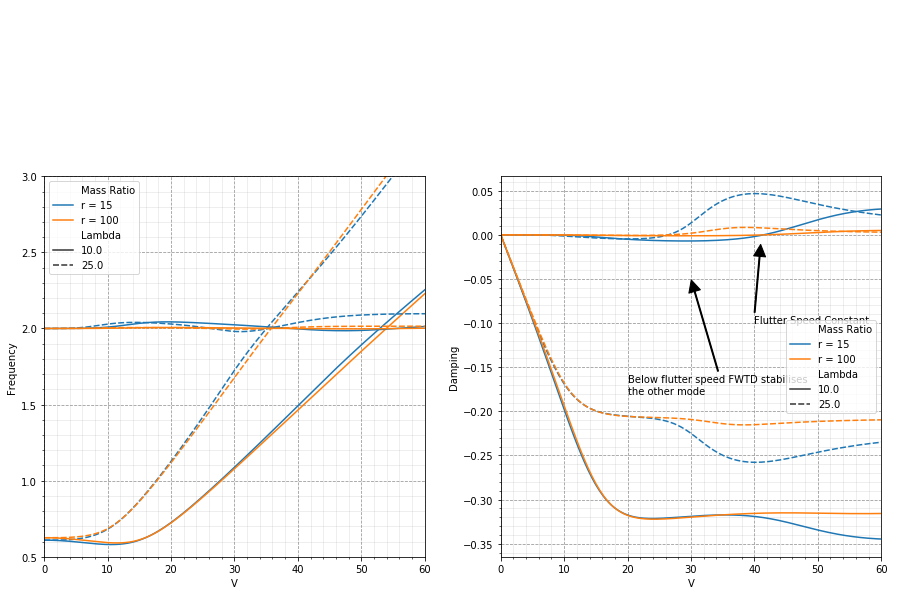

In [14]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
data = flutdfv2[(flutdfv2['Stable'])]
#data = flutdfv2[flutdfv2['Lambda']==10]
data = flutdfv2
fig, axes = plt.subplots(1,2,figsize=(15,7))


sns.lineplot(data=data[data['Mode']==0],x='V',y='Frequency',hue='Mass Ratio',style='Lambda',ax=axes[0],legend=False)
sns.lineplot(data=data[data['Mode']==1],x='V',y='Frequency',hue='Mass Ratio',style='Lambda',ax=axes[0])
sns.lineplot(data=data[data['Mode']==0],x='V',y='Damping',hue='Mass Ratio',style='Lambda',ax=axes[1],legend=False)
sns.lineplot(data=data[data['Mode']==1],x='V',y='Damping',hue='Mass Ratio',style='Lambda',ax=axes[1])


axes[1].annotate('Flutter Speed Constant',xy=(41, -0.01),  xycoords='data',
            xytext=(40, -0.1),
            arrowprops=dict(facecolor='black', shrink=0.01,width=1))

axes[1].annotate('Below flutter speed FWTD stabilises \nthe other mode',xy=(30, -0.05),  xycoords='data',
            xytext=(20, -0.18),
            arrowprops=dict(facecolor='black', shrink=0.01,width=1))

axes[1].annotate('Instability has a peak, and its magnitude is a function of mass ratio and flare angle ',xy=(40, 0.2),  xycoords='data',
            xytext=(-3.5, 0.25),
            arrowprops=dict(facecolor='black', shrink=0.01,width=1))

#sns.scatterplot(data=data,x='V',y='Damping',hue='Mass Ratio',style='Lambda',ax=axes[1],s=10,edgecolor = 'none')
for i in [0,1]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[i].set(xlim=(0,60))
axes[0].set(ylim=(0.5,3))

In [14]:
# get info for the first unstable point for each AoA

aoas = data['aoa'].unique()
idx = []

data = flutdfv2[~flutdfv2['Stable']]
for i in data['aoa'].unique():
    idx.append(data[data['aoa']==i].sort_values(by=['V'],axis=0).head(1).index[0])
    
res = flutdfv2.iloc[idx].copy()
res['eta'] = res.apply(lambda row: np.rad2deg(row.lp[0]),axis=1)
res[['aoa','V','eta']]

KeyError: 'aoa'